# Загрузка Order book из CSV

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [74]:
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [ ]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [8]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-09-23'"
df_history = db.query(sql_history)
#df_history.set_index('dt', inplace=True)

In [12]:
df_history.set_index('dt', inplace=True)

In [13]:
df_history.shape

(1853990, 11)

In [14]:
df_history.sort_values('dt').head()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-09-23 00:00:01,NaN,19,binance,ETH/USDT,242.139999,0.18914,None,sell,36885589.0,disk,2018-09-23 00:00:41.7633333
2018-09-23 00:00:01,NaN,19,binance,ETH/USDT,242.130005,0.14056,None,sell,36885590.0,disk,2018-09-23 00:00:41.7633333
2018-09-23 00:00:03,NaN,19,binance,ETH/USDT,242.130005,0.27220,None,sell,36885591.0,disk,2018-09-23 00:00:41.7633333
2018-09-23 00:00:13,NaN,19,binance,ETH/USDT,241.929993,0.06849,None,sell,36885595.0,disk,2018-09-23 00:00:41.7633333
2018-09-23 00:00:13,NaN,19,binance,ETH/USDT,241.970001,0.16609,None,sell,36885594.0,disk,2018-09-23 00:00:41.7633333


In [20]:
#выбор анализируемого диапазона и группировка по минутам
df_history_period = df_history['2018-10-02 03:00':'2018-10-02 23:00'].resample('T').mean()
df_history_period.head()

,rownum,id_ex_pair,price,amount,id
dt,,,,,
2018-10-02 03:00:00,NaN,19,231.519747,0.775694,3.825204e+07
2018-10-02 03:01:00,NaN,19,231.956567,2.868537,3.825214e+07
2018-10-02 03:02:00,NaN,19,232.030737,3.254595,3.825226e+07
2018-10-02 03:03:00,NaN,19,231.950688,6.576971,3.825235e+07
2018-10-02 03:04:00,NaN,19,231.942071,6.635251,3.825243e+07


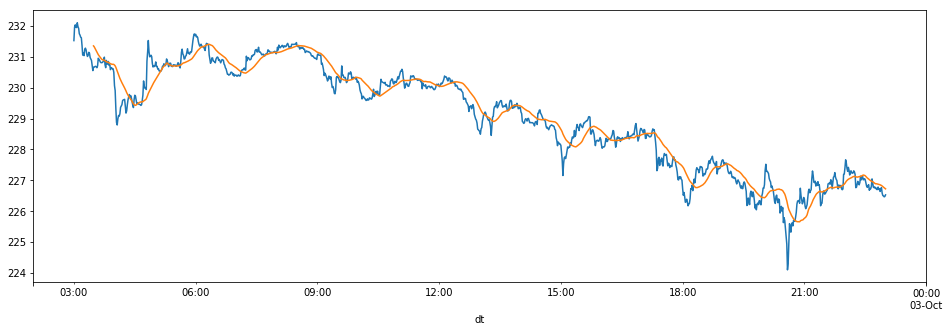

In [22]:
# выбор окна сдвига, удаление nan и график цены и скольз.среднего
window = 30

df_history_period['ma'] = df_history_period.price.rolling(window).mean()
df_history_period.ma.dropna(inplace=True)
df_history_period.price.plot()
df_history_period.ma.plot(figsize=(16,5))

In [ ]:
df_history_period.to_excel('ma_test.xlsx')

In [ ]:
df_history_period.head(20)

In [ ]:
df_history_period['IsUp'] = np.where(df_history_period.price > df_history_period.price.shift(1), 1, 0)

In [ ]:
df_history_period['ma_signal'] = np.where(df_history_period.ma > df_history_period.price.shift(1), 1, 0)

In [ ]:
df_history_period.head(15)

In [ ]:
#ma_accuracy = df_history_period.ma_signal.sum() / df_history_period.ma_signal.count()
df_history_period['ma_acc'] = np.where(df_history_period.ma_signal == df_history_period.IsUp, 1, 0)
ma_accuracy = df_history_period.ma_acc.sum() / df_history_period.ma_acc.count()
print ('MA accuracy = ', ma_accuracy)
# print(df_history_period.ma_signal.sum())
# print(df_history_period.ma_signal.count())

In [ ]:
df_history_period.head()

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [31]:
#df_history_period.price.pct_change().dropna()
#_= plot_acf(df_history_period.resample('H').price.mean(), lags=21, alpha=1)

In [33]:
df_history.resample('H').price.mean().count()

428

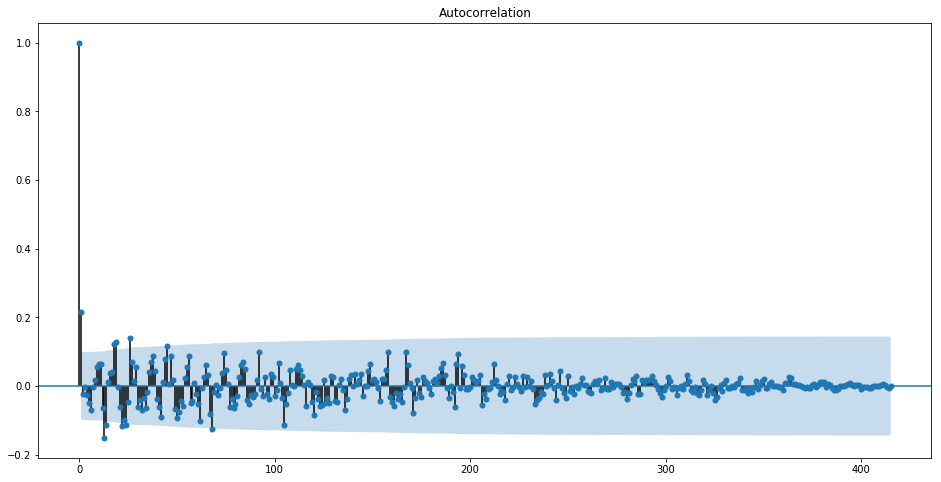

In [40]:
# детализация по часам за 8 дней
plt.rcParams['figure.figsize'] = [16, 8]
_= plot_acf(df_history.resample('H').price.mean().pct_change().dropna(), lags=415, alpha=0.05)

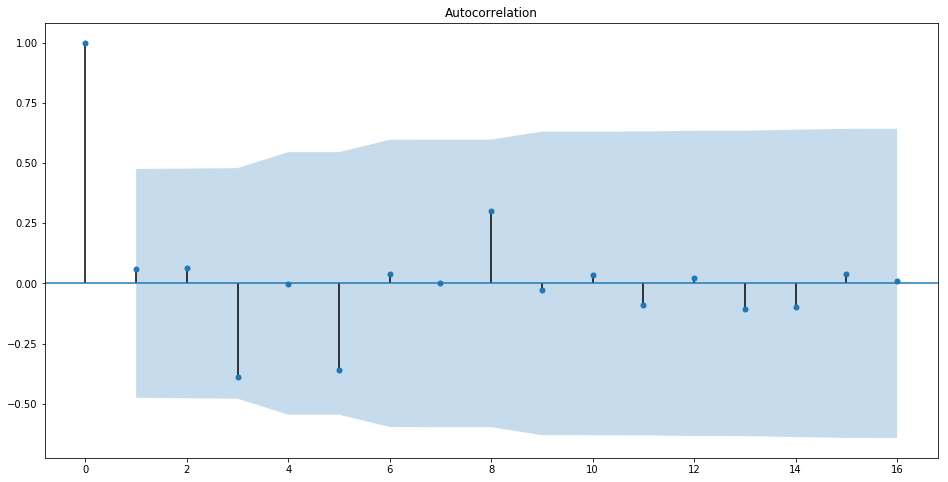

In [44]:
# детализация по дням за 7 дней
_= plot_acf(df_history.resample('D').price.mean().pct_change().dropna(), lags=16, alpha=0.05)

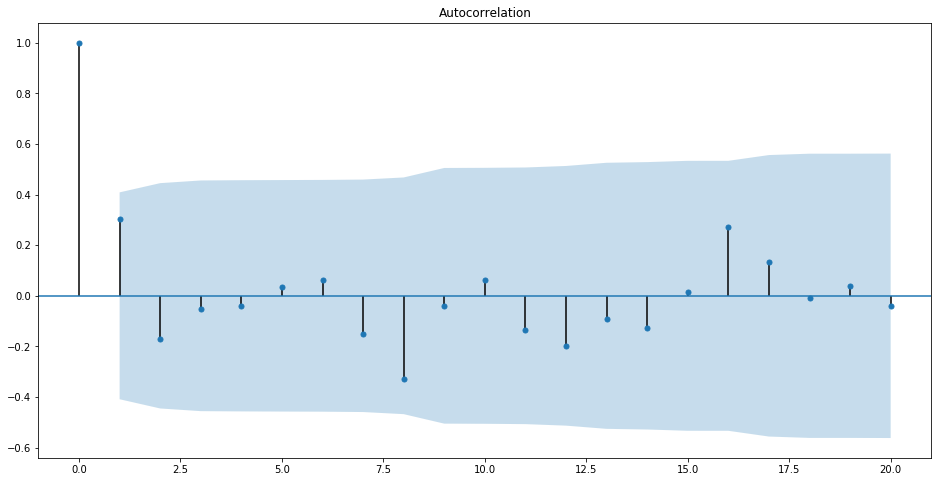

In [45]:
# детализация по часам за 1 день 3 октября

_= plot_acf(df_history['2018-10-03 00:00':'2018-10-03 23:59'].resample('H').price.mean().pct_change().dropna(), lags=20, alpha=0.05)

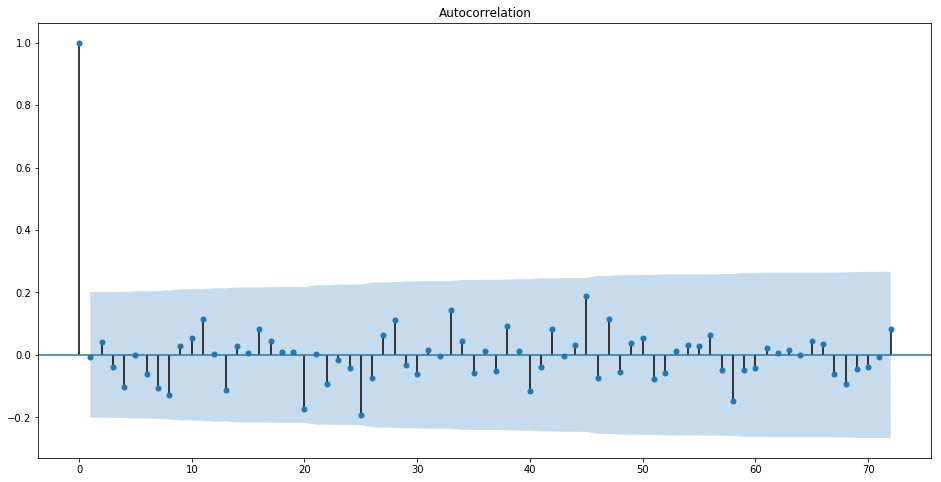

In [46]:
# детализация по часам за 3 дня 1,2,3 октября

_ = plot_acf(df_history['2018-10-03 00:00':'2018-10-06 23:59'].resample('H').price.mean().pct_change().dropna(), lags=72, alpha=0.05)
#plt.plot()

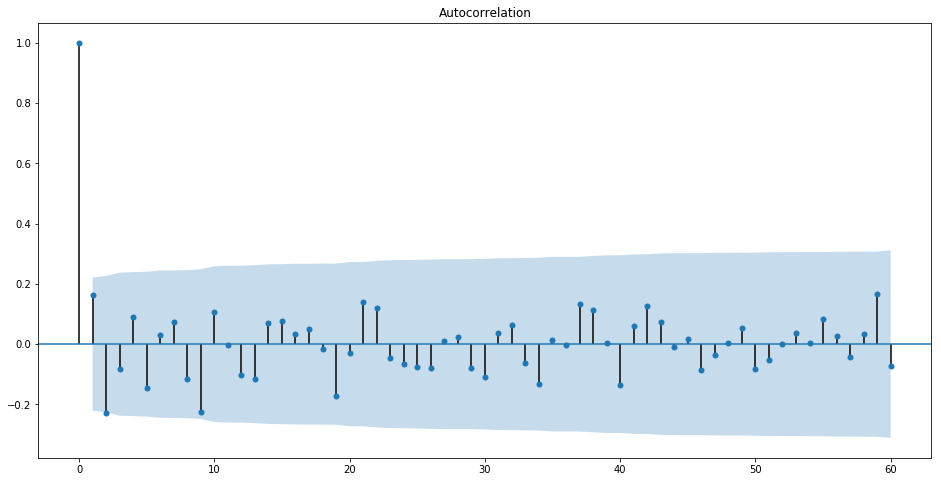

In [110]:
# детализация по минутам
_= plot_acf(df_history['2018-09-28 0:00':'2018-10-06 21:00'].resample('160min').price.mean().pct_change().dropna(), lags=1)

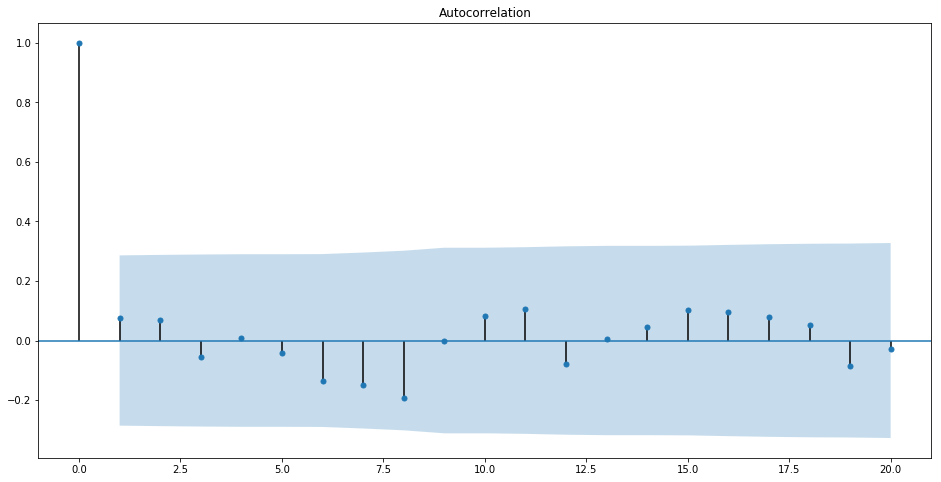

In [86]:
_= plot_acf(df_history['2018-10-03 00:00':'2018-10-04 23:59'].resample('H').price.mean().pct_change().dropna(), lags=20, alpha=0.05)

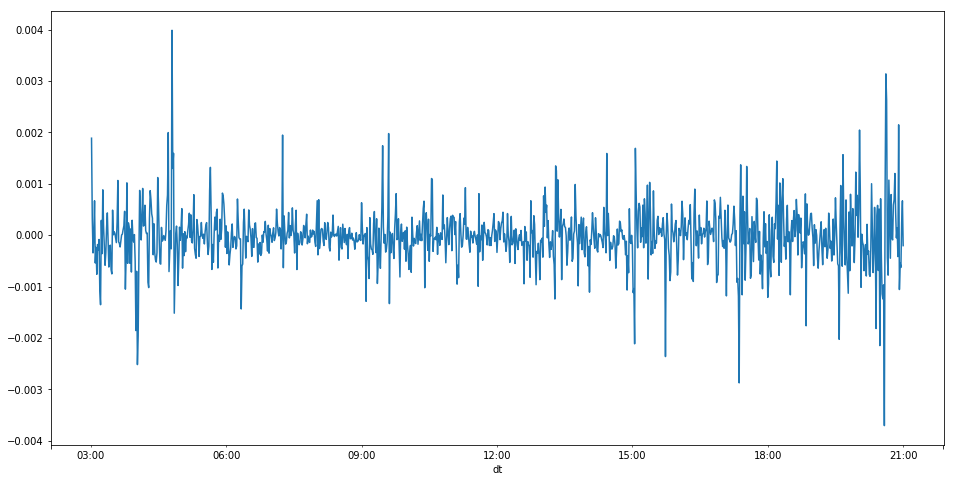

In [73]:
df_history['2018-10-02 3:00':'2018-10-02 21:00'].resample('1min').price.mean().pct_change().dropna().plot()

In [85]:
results = adfuller(df_history['2018-10-02 3:00':'2018-10-02 21:00'].price.pct_change().dropna())
print(f"p-значение для абсолютных цен равно {results[1]*100:.2f}%")

p-значение для абсолютных цен равно 0.00%


In [84]:
results

(-46.103994311257495,
 0.0,
 69,
 105838,
 {'1%': -3.43041178743559,
  '5%': -2.861567309095109,
  '10%': -2.566784535672826},
 -1088547.8237145182)

In [81]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        data series
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}
    regression : {'c','ct','ctt','nc'}
        Constant and trend order to include in regression
    
        * 'c' : constant only (default)
        * 'ct' : constant and trend
        * 'ctt' : constant, and linear and quadratic trend
        * 'nc' : no constant, no trend
    autolag : {'AIC', 'BIC', 't-stat', None}
        * if None, then maxlag lags are used
        * if 'AIC' (default) or 'BIC', then the number of lags is chosen
          to minimize the corresponding information 

In [122]:
from statsmodels.tsa.stattools import acf

In [129]:
acf(df_history['2018-09-28 0:00':'2018-10-06 21:00'].resample('120min').price.mean().pct_change().dropna(), nlags=1)

array([1.        , 0.25501853])

In [128]:
for i in range (2, 30):
    acf(df_history['2018-09-28 0:00':'2018-10-06 21:00'].resample('i').price.mean().pct_change().dropna(), nlags=1)

ValueError: Invalid frequency: i